In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import time
import datetime
import urllib.request, json
from datetime import date, datetime, timedelta
import matplotlib.gridspec as gridspec
from pylab import figure, text, scatter, show
import math
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## data downloader

In [2]:
ticker_file = 'data/stock_ticker_usa.txt'

# start_date = '01/01/2020'
# end_date = '05/01/2020'

today = date.today()
end_date = today.strftime("%m/%d/%Y")

yearago = datetime.now() + timedelta(days=-365*5)
start_date = yearago.strftime("%m/%d/%Y")

print ('Start date', start_date)
print ('End date', end_date)

Start date 05/04/2015
End date 05/02/2020


In [3]:
def calc_time(date_string):
    uu = time.mktime(datetime.strptime(date_string, "%m/%d/%Y").timetuple())
    return str(int(uu-18000))

In [4]:
base_url = 'https://query2.finance.yahoo.com/v8/finance/chart/<ticker>?formatted=true&crumb=1HexGHzkPFp&lang=en-US&region=US&interval=1d&period1=<start_time>&period2=<end_time>&events=div%7Csplit&corsDomain=finance.yahoo.com'

start_time = calc_time(start_date)
end_time = calc_time(end_date)
base_url = base_url.replace('<start_time>', start_time).replace('<end_time>', end_time)
print ('base_url', base_url)

base_url https://query2.finance.yahoo.com/v8/finance/chart/<ticker>?formatted=true&crumb=1HexGHzkPFp&lang=en-US&region=US&interval=1d&period1=1430697600&period2=1588377600&events=div%7Csplit&corsDomain=finance.yahoo.com


In [5]:
## read ticker file
tickers = list()

with open(ticker_file, 'r') as lines:
    for line in lines:
        parts = line.split(',')
        tup = (parts[0].strip(), parts[1].strip().upper())
        tickers.append(tup)
print ('Len of tickers: ', len(tickers))
print ('Sample ticker:', tickers[0])

Len of tickers:  105
Sample ticker: ('3M', 'MMM')


In [6]:
def period_analyzer(arr, tail_days):
    result = dict()
    trading_days = math.floor(tail_days/7*5)
    period_arr = arr[-trading_days:]
    current = period_arr[-1]

    period_high = max(period_arr)
    period_low = min(period_arr)
    diff_high = (current-period_high)/period_high
    diff_low = (current-period_low)/period_low
    period_percentile = (current - period_low) / (period_high-period_low)
    if tail_days==365:
        result = {'52 weeks high':period_high, '52 weeks low':period_low, 
              '% below 52w_high':diff_high, '% above 52w_low':diff_low,'52w percentile':period_percentile}
    else:
        result = {'period high':period_high, 'period low':period_low, 
              '% below period_high':diff_high, '% above period_low':diff_low,'period percentile':period_percentile}
    return result

In [7]:
## Download data
dataset = []

error=0
# ignore last few days, in case
last_months_to_ignore = 3
days = last_months_to_ignore*22

for line in tickers:
    try:
        ticker_js = dict()
        tick_url = base_url.replace('<ticker>', line[1] )
        with urllib.request.urlopen(tick_url) as url:
            data = json.loads(url.read().decode())
            arr = data['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']
            arr = [ round(i,0) for i in arr if i is not None]
            
            # regression 5 years
            m,b = np.polyfit(range(len(arr)), arr, 1)
            # regression 5 years - last_months_to_ignore
            m_i, b_i = np.polyfit(range(len(arr[0:-1*days])), arr[0:-1*days], 1)
            
            ticker_js = {'name':line[0], 'ticker':line[1], 
                         'data':arr, '5y_slope_all':round(m,3), '5y_bias_all':round(b,3),
                         '5y_slope':round(m_i,3), '5y_bias':round(b_i,3), 'current':arr[-1]}
            
            # analysis last year
            last_year_js = period_analyzer(arr, tail_days=365)
            ticker_js.update(last_year_js)
            
            # analysis last 3 months
            last_3mos_js = period_analyzer(arr, tail_days=90)
            ticker_js.update(last_3mos_js)
            
            dataset.append(ticker_js)
    except:
        error = error+1

print ('Size of dataset', len(dataset))

Size of dataset 105


In [8]:
df = pd.DataFrame.from_dict(dataset, orient='columns')
cols = ['name', 'current', '5y_slope', '52w percentile', '% above 52w_low','% below 52w_high']
df = df[cols]
df = df[df['5y_slope'] > 0.0]

"""
score:
high '5y_slope'
low '52w percentile'
"""
topn = 20
df['score'] = df.apply(lambda x: x['5y_slope']*0.6 - x['52w percentile']*0.4, axis=1)
df = df.sort_values('score',ascending = False)
top_df = df.head(topn)

top_stocks = top_df['name'].values.squeeze().tolist()

top_df.head(topn)

,name,current,5y_slope,52w percentile,% above 52w_low,% below 52w_high,score
5,Amazon,2286.0,1.426,0.764115,0.363148,-0.075990,0.549954
41,Google,1317.0,0.597,0.572016,0.267565,-0.136393,0.129393
16,Boeing,133.0,0.278,0.132404,0.400000,-0.651832,0.113838
85,Transdigm,349.0,0.297,0.250000,0.418699,-0.469605,0.078200
72,Southwest Airlines,29.0,0.017,0.000000,0.000000,-0.500000,0.010200
94,United Technologies,58.0,0.046,0.075472,0.160000,-0.628205,-0.002589
93,United Airlines,27.0,0.036,0.081081,0.285714,-0.715789,-0.010832
27,Delta,24.0,0.016,0.073171,0.142857,-0.612903,-0.019668
17,Blueprint Medicines,57.0,0.065,0.169811,0.187500,-0.435644,-0.028925
102,Wells Fargo,28.0,0.004,0.103448,0.120000,-0.481481,-0.038979


## Plots

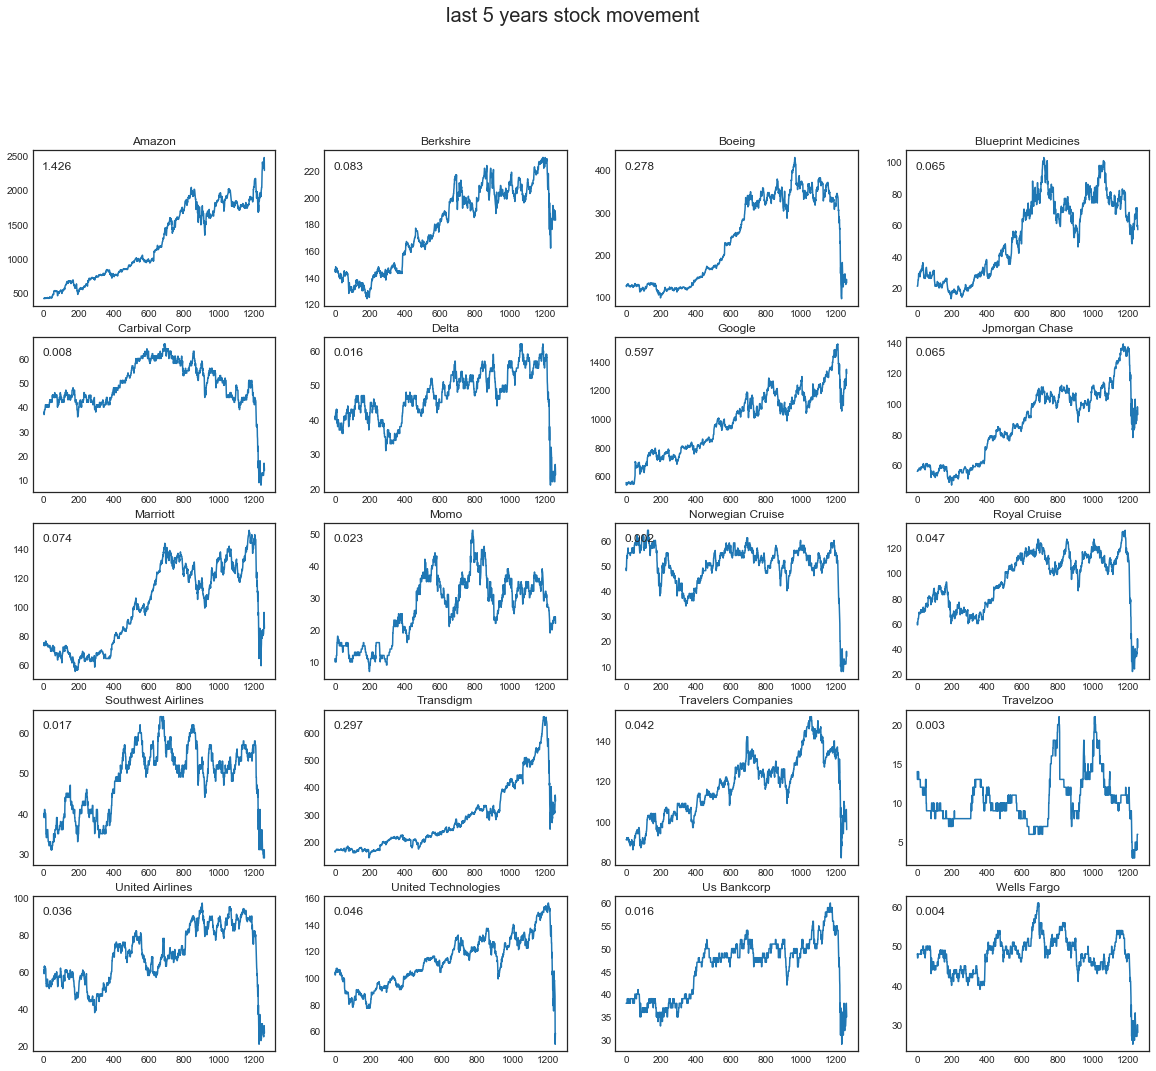

In [9]:
new_dataset = [i for i in dataset if i['name'] in top_stocks]

## plots
length = len(new_dataset)+1
cols=4
rows=math.ceil(length/4)

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
fig.suptitle('last 5 years stock movement', fontsize=20)
for i in range(len(new_dataset)):
    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(new_dataset[i]['name'])
    text(0.1, 0.9, new_dataset[i]['5y_slope'] , ha='center', va='center', transform=ax.transAxes,  fontsize=12)
    data = new_dataset[i]['data']
    ax.plot(range(len(data)), data)
plt.show()